# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# SGD_rank

##### Ver:: A2_V6
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl

In [5]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
'FL':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'FL'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'cell.labels'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'cell.labels',
'train_x_partition' : 'X_pca', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.9, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'weight_penalty': 'laplacian', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian"
}

# Transductive workflow
- First we train a model on a subset of our data which we will then later use to generalise across our dataset.

- We sample our data using a set of empirical priors based on the known distribution of celltype labels, we then consider a weight to represent the liklihood of sampling by taking the sum of weights for each vertice sharing labels divided by vertices that have different labels. 

# Bayesian_balanced_stratified_sampling
This function, bayesian_balanced_stratified_sampling, performs stratified sampling on single-cell data stored in an AnnData object. It uses empirical Bayesian updating to balance the representation of each cell type (label) in the data. The sampling process considers the neighborhood relationships between cells, which helps maintain the local structure of the original data.

The sampling can be adjusted with several options, including:

equal_allocation: If enabled, each label gets an equal share of the total sample size. Otherwise, the sample size for each label is proportional to its prior probability.
replace: If enabled, sampling is done with replacement, allowing the model to create clones of cells.
iterations: Determines the number of times the sampling process is repeated, updating the label probabilities in each iteration.
The output is a new AnnData object containing the sampled cells and the indices of the sampled cells.

If left as default, underepresented states will naturally be prioritised in sampling as iterations increases, thus if you are experiencing issues with under representation, increase iterations. 

- Representation priority represents a wighting factor used to recover rare-states. 
- Prioritisation factor, this will heavily bias the sampling of under-represented states

In [9]:
adata.obsp

PairwiseArrays with keys: 

In [6]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

if model_params['sample_data_knn'] != False:
    print('Empirical bayes sampling option selected')
    adata_samp, indices, weights = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)
    scent.plot_sampling_metrics(adata,adata_samp, **model_params)
    #adata = adata_samp.to_memory()
print('adata_loaded')

Loading anndata from web source


100%|██████████| 2.60G/2.60G [01:15<00:00, 36.8MB/s]


Empirical bayes sampling option selected
You are using sampling with replacement, this allows the model to create clones of cells


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/scentinel/general_utlities.py:735: UserWarning: warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states
  warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')


KeyError: 'neighbors'

# This is super fast!!
 This means that the weight of an edge between two nodes will be reduced if either of the nodes has many other connections, and will be increased if either of the nodes has fewer other connections.
 
- elements can be interpreted as a measure of the importance of the connections between nodes, taking into account the overall connectivity of the nodes. This can help to emphasize the connections between nodes that are relatively isolated and de-emphasize the connections between nodes that are highly connected.

In [5]:
import numpy as np
import pandas as pd

# Example adjacency matrix A
A = np.array([[0, 1, 1, 0],
              [1, 0, 1, 0],
              [1, 1, 0, 1],
              [0, 0, 1, 0]])

# Degree calculation
D = np.sum(A, axis=1)

# Inverse square root degree diagonal matrix S
S = np.diag(1/np.sqrt(D))

# Modified adjacency matrix M
M = S @ A @ S

A, D, S, M


(array([[0, 1, 1, 0],
        [1, 0, 1, 0],
        [1, 1, 0, 1],
        [0, 0, 1, 0]]),
 array([2, 2, 3, 1]),
 array([[0.70710678, 0.        , 0.        , 0.        ],
        [0.        , 0.70710678, 0.        , 0.        ],
        [0.        , 0.        , 0.57735027, 0.        ],
        [0.        , 0.        , 0.        , 1.        ]]),
 array([[0.        , 0.5       , 0.40824829, 0.        ],
        [0.5       , 0.        , 0.40824829, 0.        ],
        [0.40824829, 0.40824829, 0.        , 0.57735027],
        [0.        , 0.        , 0.57735027, 0.        ]]))

In [ ]:
np.diag(D)

In [9]:
pd.DataFrame(S)

,0,1,2,3
0,0.707107,0.000000,0.00000,0.0
1,0.000000,0.707107,0.00000,0.0
2,0.000000,0.000000,0.57735,0.0
3,0.000000,0.000000,0.00000,1.0


In [7]:
pd.DataFrame(A)

,0,1,2,3
0,0,1,1,0
1,1,0,1,0
2,1,1,0,1
3,0,0,1,0


In [6]:
pd.DataFrame(S)

,0,1,2,3
0,0.707107,0.000000,0.00000,0.0
1,0.000000,0.707107,0.00000,0.0
2,0.000000,0.000000,0.57735,0.0
3,0.000000,0.000000,0.00000,1.0


In [12]:
pd.DataFrame(M)

,0,1,2,3
0,0.000000,0.500000,0.408248,0.00000
1,0.500000,0.000000,0.408248,0.00000
2,0.408248,0.408248,0.000000,0.57735
3,0.000000,0.000000,0.577350,0.00000


In [ ]:
def pagerank(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    Calculate the PageRank of each node in a graph.
    
    Parameters:
    M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    num_iterations (int): The maximum number of iterations to perform.
    d (float): The damping factor.
    tolerance (float): The tolerance for convergence.
    
    Returns:
    numpy.ndarray: The PageRank score for each node in the graph.
    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    damping = ((1 - d) / N) * np.ones((N, 1))
    last_v = np.ones((N, 1)) * np.inf
    l2_dic = {}
    for _ in range(num_iterations):
        last_v = v
        v = d * M @ v + damping
        l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(_))
            break
            
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()))
    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.grid(True)
    plt.show()

    return v, l2_dic


def SGDpagerank(M, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, 
             full_batch_update_iters=10, dip_window=5, plateau_iterations=5, sampling_method='probability_based'):
    """
    Calculate the PageRank of each node in a graph using a mini-batch SGD approach.

    Parameters:
    - M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    - num_iterations (int): The maximum number of iterations to perform.
    - mini_batch_size (int): Number of nodes to sample in each iteration.
    - initial_learning_rate (float): Initial learning rate for the SGD updates.
    - tolerance (float): Convergence threshold.
    - d (float): Damping factor.
    - full_batch_update_iters (int): Number of iterations for the full-batch update phase.
    - dip_window (int): Window size for smoothing L2 norms.
    - plateau_iterations (int): Number of consecutive iterations where the gradient should remain stable for early stopping.
    - sampling_method (str): Method to sample nodes ('probability_based' or 'cyclic').

    Returns:
    - numpy.ndarray: The PageRank score for each node in the graph.
    - dict: L2 norms for each iteration.
    """
    
    # Initialize the size of the matrix
    N = M.shape[1]
    
    # Initialize PageRank vector with random values and normalize
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    
    # Initialize last PageRank vector to infinity for convergence checks
    last_v = np.ones((N, 1)) * np.inf
    
    # Dictionary to store L2 norms for each iteration
    l2_dic = {}
    
    # Set to keep track of visited nodes (for cyclic sampling)
    visited_nodes = set()
    
    # Initialize counters and lists for plateau and dip detection
    plateau_count = 0
    dips_detected = 0
    dip_positions = []

    # Initialize an array to keep track of node visit counts (for probability-based sampling)
    visited_counts = np.zeros(N)

    for iter_ in range(num_iterations):
        # Decay the learning rate to ensure convergence
        learning_rate = initial_learning_rate / ((1 + iter_)/10)
        
        # Probability-based sampling
        if sampling_method == 'probability_based':
            probabilities = 1 / (1 + visited_counts)
            probabilities /= probabilities.sum()
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        # Cyclic sampling
        elif sampling_method == 'cyclic':
            if len(visited_nodes) < N:
                remaining_nodes = list(set(range(N)) - visited_nodes)
                mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
            else:
                mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
            # Update the set of visited nodes
            visited_nodes.update(mini_batch_indices)
        
        # Update node visit counts
        visited_counts[mini_batch_indices] += 1
        
        # Extract the mini-batch from the matrix and the PageRank vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices]
        
        # Store the current PageRank values for convergence checks
        last_v = v_mini_batch
        
        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rate * M_mini_batch @ v) + ((1 - d) / N)
        v[mini_batch_indices] = v_mini_batch
        
        # Compute and store the L2 norm of the difference between the current and last PageRank values
        l2_norm = np.linalg.norm(v_mini_batch - last_v)
        l2_dic[iter_] = l2_norm
        
        # Compute smoothed L2 norms for dip detection
        if iter_ > dip_window:
            smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
            gradient = smoothed_values[-1] - smoothed_values[-2]
            
            # Detect dips in the smoothed L2 norms
            if gradient < -1.5 * np.std(smoothed_values):
                dips_detected += 1
                dip_positions.append(iter_)

        # Check for convergence
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(iter_))
            break
        
        # Early stopping based on smoothed L2 norms
        gradient_variance_window = 10
        if iter_ > gradient_variance_window:
            gradient_values = np.diff(smoothed_values)
            variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
            if sampling_method == 'probability_based' and dips_detected == 1:
                if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            elif sampling_method == 'cyclic' and dips_detected > 1:
                if abs(gradient) < 0.5 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            # If the gradient has been stable for a number of iterations, stop early
            if plateau_count >= plateau_iterations:
                print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
                break

    # If the algorithm hasn't converged in the given number of iterations, display a message
    if iter_ == num_iterations-1:
        print('pagerank model did not converge during the mini-batch phase')
    
    # Refine the PageRank values using full-batch updates
    print("Proceeding on to perform fine-tuning across full-batch")
    for _ in range(full_batch_update_iters):
        last_v_global = v.copy()
        v = d * (M @ v) + ((1 - d) / N)
        l2_norm_global = np.linalg.norm(v - last_v_global)
        l2_dic[iter_ + _ + 1] = l2_norm_global
    
    # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
    smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
    plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
    for dip in dip_positions:
        plt.axvline(x=dip, color='g', linestyle='--')
    
    if plateau_count >= plateau_iterations:
        plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

    # Highlight the global fine-tuning iterations
    plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if sampling_method == 'probability_based':
        print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
        print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
    elif sampling_method == 'cyclic':
        print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
        print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    
    return v, l2_dic


# Compute the PageRank of each node in the graph
#pagerank_scores, l2_norm_dic = pagerank(csr_matrix, num_iterations=10000, d=0.85, tolerance=1e-6)

#pagerank_scores, l2_norm_dic = SGDpagerank(csr_matrix, num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100)

You are using sampling with replacement, this allows the model to create clones of cells
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Converged at iteration 683
Proceeding on to perform fine-tuning across full-batch


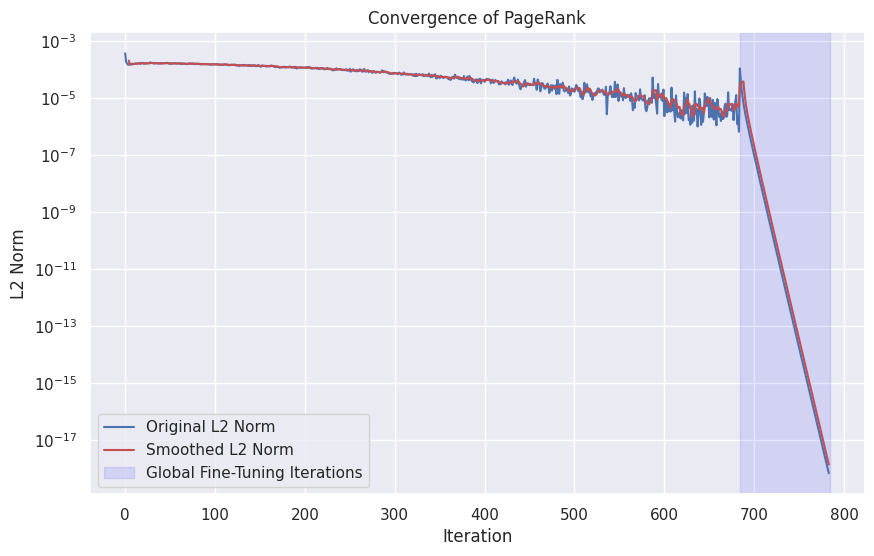

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [9]:
import matplotlib.pyplot as plt
import scipy
import warnings
from scipy.stats import entropy
import math
from collections import Counter


#adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')
representation_priority = 0.8
equal_allocation=False
replace = True
feat_use = "cell_type"
knn_key = 'neighbors'
sampling_rate = 0.1
iterations = 10
weight_penalty = 'laplacian_SGD_pagerank'
pl_label_entropy = False
resample_clones = True # resamples clones, atempts to reduce the oversampled clone population and increase diversity of sampling, whilst preserving the structure of the data


if equal_allocation:
    print('You are using an equal allocation mode of sampling, be warned that this can cause errors if the smaller populations are insufficient in number, consider replace == True')

if replace == True:
    print('You are using sampling with replacement, this allows the model to create clones of cells')

if representation_priority > 0.8:
    print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
    warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')

# Convert string labels to integer labels
unique_labels, indices = np.unique(adata.obs[feat_use], return_inverse=True)
adata.obs['int.labels'] = indices

# Calculate frequencies (prior probabilities)
label_counts = np.bincount(indices)
frequencies = label_counts / label_counts.sum()

# Create a dictionary where keys are label indices and values are their frequencies (prior probabilities)
prior_distribution = dict(zip(range(len(unique_labels)), frequencies))

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

# Initialize label probabilities with prior distribution
label_probs = prior_distribution.copy()

# Get indices for each label
label_indices = {label: np.where(adata.obs['int.labels'] == label)[0] for label in range(len(unique_labels))}

# Calculate total sample size and sample size per label for equal allocation
total_sample_size = int(sampling_rate * adata.shape[0])
sample_size_per_label = total_sample_size // len(unique_labels)

if weight_penalty == 'entropy_distance':
    print('Using distance-entropy penalisation weights, this module is multi-threaded and quite compute intensive. If facing issues, use connectivity_ratio instead')
    # Calculate entropy for each neighborhood in advance
    all_labels = adata.obs['int.labels'].values
    neighborhood_indices = [np.nonzero(neighborhood_matrix[idx])[1] for idx in range(adata.shape[0])]
    # Calculate entropy for each cell in parallel
    import multiprocessing
    with multiprocessing.Pool() as pool:
            neighborhood_entropies = np.array(list(pool.map(calculate_entropy, [(all_labels, idx) for idx in neighborhood_indices])))
            
elif weight_penalty == "laplacian":# This is essentially an attention score
    print('Using Laplacian penalty term, this is similar in concept to an attention score in GANs')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix

            
elif weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = SGDpagerank(csr_matrix, num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100)
    

    
# Create a dictionary to store the neighborhood entropy for each label at each iteration
neighborhood_entropies_iter = {label: [] for label in range(len(unique_labels))}
sampling_probabilities_over_iterations = np.zeros((iterations, len(unique_labels)))
for _ in range(iterations):
    print('Iteration: {}'.format(_))
    # Stratified sampling within each neighborhood for each label
    all_weights = []
    all_indices = []
    for label in label_indices.keys():
        indices = label_indices[label]
        other_indices = [idx for key, indices in label_indices.items() if key != label for idx in indices]

        neighborhoods = neighborhood_matrix[indices]  # select neighborhoods for the current label

        # Here we determine the liklighood that a sampled cell forms consistant neigthborhood
        # We take the sum of weights of the same labels within each neighborhood to represent the liklihood of a cell forming tight communities (px)
        # We divide p by the sum of weights of different labels in the same neighborhood to represent the liklihood of there being more than one state sharing the neighborhood. (nx)
        # We take the ratio of (px/nx) to represent the liklihood that a label represents consistant neighborhoods that are sufficiently independent
        # e.g The sum of weights of cells with different labels in a neighborhood relative to our observed cell should be low if the label for the cell is good. thus the ratio should be high.   
        if weight_penalty == 'connectivity_ratio':
            same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
            same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication
            same_label_neighborhoods = neighborhoods[:, indices]   # get neighborhoods of same-label cells
            different_label_neighborhoods = neighborhoods[:,other_indices]  # get neighborhoods of different-label cells
            same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
            different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()
            # we now compute a hybrid weighting scheme, where cells with more defined neigthborhood structure are prioritised. Howevever we do not want this over penalise, so we recover underrepresented cells with a inverse weighting parameter
            # Calculate the ratio of same-label weights to different-label weights
            # Add a small constant in the denominator to avoid division by zero
            weights = (same_label_weights )/ (different_label_weights + 1e-8) # if same label sum distances are 0, do not consider this cell
            weights = weights/np.sum(weights) # this normnalisation means that every label has normalised set of weights to bias selection

         # Here we determine the liklighood that a sampled cell forms consistant neigthborhood using the mean distance to all neighbors * by the entropy of the neighborhood 

        if weight_penalty == 'entropy_distance':
            # We take neighborhoods that share the same labels and compute the sum of weights between same labels
#             np.array(neighborhoods[:, indices].sum(axis=1)).ravel()
            same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
            same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication
            same_label_neighborhoods = neighborhoods[:, indices] 
            weights = (np.array(same_label_neighborhoods.sum(axis=1)).ravel()+ 1e-8) # We take the sum of weights to all neighbors of the same label here
            #1/weights give us the inverse where big weights are big distances
            weights *= (1/(neighborhood_entropies[indices] + 1e-8))  # use pre-computed entropies
#             weights = weights
            weights = weights / np.sum(weights) # this normnalisation means that every label has normalised set of weights to bias selection
    
        elif weight_penalty == "laplacian":# This is essentially an attention score
            # This is essentially the calculation of the Laplacian of the graph.
            # Compute the attention or importance of each cell to their neighbors
            attention_scores=normalized_matrix[indices].sum(axis = 1)
            weights = ((np.array(attention_scores)).flatten())
            
        elif weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score with pagerank and stochastic gradient descent
            # This is essentially the calculation of the Laplacian of the graph.
            # Compute the attention or importance of each cell to their neighbors
            attention_scores_= [attention_scores[i] for i in indices]
            weights = ((np.array(attention_scores_)).flatten())
            
        # Update weights based on representation priority and label probabilities
        # This should be a combination of the neighborhood-based weights and the label probability-based weights
        # we intriduce a iteration decay for each iteration for label probs here
        if representation_priority != 0:
            #weights = weights * ((((1 / (label_probs[label] + 1e-8))) **  (representation_priority)) )
            weights = weights * ((((1 / (label_probs[label] + 1e-8))) **  (representation_priority/(1+_))) )# we added a decaying upsampling factor to prevent iterations from over sampling under re-presented states
        else:
            #weights = weights * (((1 / (label_probs[label] + 1e-8))))
            weights = weights * (((1 / (label_probs[label] + 1e-8)))) 
        #weights = np.array(weights) / np.sum(weights)  # normalization to probabilities
        all_weights.extend(weights)
        all_indices.extend(indices)

    all_weights = np.array(all_weights) / np.sum(all_weights)  # normalization to probabilities
    
    if resample_clones == True:
        sample_indices_n_dic = {}
        for _niter in range(0,50):
            sample_indices_n = np.random.choice(all_indices, size=total_sample_size, replace=replace, p=all_weights)
            sample_indices_n_dic[_niter] = sample_indices_n
        sample_indices_n_dic
        # Combine all the samples into one list
        combined_samples = np.hstack(list(sample_indices_n_dic.values()))
        # Count the frequency of each index in the combined samples
        index_counts = Counter(combined_samples)
        # Create a new weight array where the weight of each index is its original weight divided by its count
        new_weights = np.array([all_weights[i] / (1.0 + index_counts.get(index, 0)) for i, index in enumerate(all_indices)])
        # Normalize the new weights so they sum to 1
        new_weights /= new_weights.sum()
        # Sample from the distribution with the adjusted weights
        sample_indices = np.random.choice(all_indices, size=total_sample_size, replace=True, p=new_weights)
        # The result is a new sample where the frequently appearing indices in the initial samples have a lower chance of appearing
    else:
        sample_indices = np.random.choice(all_indices, size=total_sample_size, replace=replace, p=all_weights)
    
    # Update label probabilities based on the observed sample
    sample_labels = adata.obs['int.labels'][sample_indices]
    label_counts = np.bincount(sample_labels, minlength=len(unique_labels))
    label_probs = dict(zip(range(len(unique_labels)), label_counts / label_counts.sum()+1e-8))
    # Store the sampling probabilities for this iteration
    sampling_probabilities_over_iterations[_, :] = np.array(list(label_probs.values()))

    if pl_label_entropy == True:
        # Calculate the entropy for the sampled cells
        for label in label_indices.keys():
            # Get the indices of the sampled cells for the current label
            sampled_indices = [idx for idx in sample_indices if adata.obs['int.labels'][idx] == label]
            if sampled_indices:
                # Get neighborhoods of the sampled cells
                same_label_neighborhoods = neighborhood_matrix[sampled_indices]
                # Get the indices of the connected cells
                connected_indices = same_label_neighborhoods.nonzero()[1]
                # Get the labels of the connected cells
                connected_labels = adata.obs['int.labels'].values[connected_indices]
                # Calculate the entropy for the current label
                label_counts = np.bincount(connected_labels, minlength=len(unique_labels))
                probabilities = label_counts / len(connected_indices)
                entropy_val = entropy(probabilities)
                neighborhood_entropies_iter[label].append(entropy_val)
            else:
                neighborhood_entropies_iter[label].append(None)

average_sampling_probabilities = sampling_probabilities_over_iterations.mean(axis=0)
updated_label_probs = dict(zip(range(len(unique_labels)), average_sampling_probabilities))

# Final stratified sampling using the last label_probs
label_sample_sizes = {label: int(updated_label_probs[label] * total_sample_size) for label in range(len(unique_labels))}
# Adjust sample sizes so total equals 'total_sample_size'
difference = total_sample_size - sum(label_sample_sizes.values())
label_sample_sizes[0] += difference  # adjust the first label for simplicity
final_sample_indices = []

if equal_allocation==True:
    label_sample_sizes = {label: sample_size_per_label for label in range(len(unique_labels))}

for label, sample_size in label_sample_sizes.items():
    indices = label_indices[label]
    neighborhoods = neighborhood_matrix[indices][:, indices]  # select neighborhoods for the current label

    same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
    same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication

    same_label_neighborhoods = same_label_mask @ neighborhoods @ same_label_mask  # get neighborhoods of same-label cells
    different_label_neighborhoods = neighborhoods - same_label_neighborhoods  # get neighborhoods of different-label cells

    same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
    different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()

    # Calculate the ratio of same-label weights to different-label weights
    # Add a small constant in the denominator to avoid division by zero
    #weights = same_label_weights / (different_label_weights + 1e-8)
#     weights = weights / weights.sum()  # normalization to probabilities
    specific_weights = np.array(all_weights[indices]) / np.sum(all_weights[indices])
    
    if resample_clones == True:
#         sample_indices = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
#         print('prior Non-Clone proportion == {}'.format( (len(list(set(sample_indices)))/len(sample_indices))))
        sample_indices_n_dic = {}
        for _niter in range(0,50):
            sample_indices_n = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
            sample_indices_n_dic[_niter] = sample_indices_n
        sample_indices_n_dic
        # Combine all the samples into one list
        combined_samples = np.hstack(list(sample_indices_n_dic.values()))
        # Count the frequency of each index in the combined samples
        index_counts = Counter(combined_samples)
        # Create a new weight array where the weight of each index is its original weight divided by its count
        new_weights = np.array([specific_weights[i] / (1.0 + index_counts.get(index, 0)) for i, index in enumerate(indices)])
        # Normalize the new weights so they sum to 1
        new_weights /= new_weights.sum()
        # Sample from the distribution with the adjusted weights
        sampled_indices = np.random.choice(indices, size=sample_size, replace=True, p=new_weights)
        # The result is a new sample where the frequently appearing indices in the initial samples have a lower chance of appearing
#         print('resampled Non-Clone proportion == {}'.format( (len(list(set(sample_indices)))/len(sample_indices))))
    else:
        sampled_indices = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
    
#     sampled_indices = np.random.choice(indices, size=sample_size, replace=replace, p=specific_weights)
    final_sample_indices.extend(sampled_indices)
adata_samp = adata[final_sample_indices,:]
all_weights


if pl_label_entropy == True:
    # plot entropy change per iteration
    # Calculate the number of columns for the legend
    ncol = math.ceil(len(unique_labels) / 20)  # Adjust the denominator to control the number of legend entries per column

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(5 + ncol, 5))  # Adjust as needed. The width of the axes object will be always 5.

    # Compute the initial entropies for the whole dataset
    initial_entropies = {}
    for label in label_indices.keys():
        indices = label_indices[label]
        same_label_neighborhoods = neighborhood_matrix[indices]
        connected_indices = same_label_neighborhoods.nonzero()[1]
        connected_labels = adata.obs['int.labels'].values[connected_indices]
        label_counts = np.bincount(connected_labels, minlength=len(unique_labels))
        probabilities = label_counts / len(connected_indices)
        entropy_val = entropy(probabilities)
        initial_entropies[label] = entropy_val

    # Plot the change in neighborhood entropy over iterations for each label
    for label, entropies in neighborhood_entropies_iter.items():
        # Prepend the initial entropy to the list of entropies
        all_entropies = [initial_entropies[label]] + entropies
        ax.plot(range(len(all_entropies)), all_entropies, label=unique_labels[label])

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Scaled Neighborhood Entropy')
    # Set the y-axis to logarithmic scale
    ax.set_yscale('log')
    # Place the legend outside the plot, scaled with the height of the plot and spread into columns
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., ncol=ncol)
    plt.tight_layout()
    plt.show()
    
    weights_out = {}
    weights_out['all_weights'] = all_weights
    weights_out['all_indices'] = all_indices
    
#adata_samp, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, **model_params)

# Non-stratified attention-based sampler
- Here our objective is to create a set of attention-scores which help prioritise nodes in sparser regions in our graph
- We then use the page-rank alg on the augmented graph to help identify nodes which are important "hubs"
- We compute sil score vs the original graph to check the 

In [35]:
adatas_dict

{'pan_fetal_wget': 'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
 'YS_wget': 'https://app.cellatlas.io/yolk-sac/dataset/23/download',
 'YS_local': '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
 'YS_pre_agm': 'https://app.cellatlas.io/yolk-sac/dataset/10/download',
 'FLIV_wget': 'https://app.cellatlas.io/fetal-liver/dataset/1/download',
 'int_atlas_sub': '/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
 'int_atlas_full': '/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad'}

In [ ]:
adata =  scent.load_adatas(adatas_dict, data_merge, 'int_atlas_full', QC_normalise, backed='r')

Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
pagerank model did not converge during the mini-batch phase
Proceeding on to perform fine-tuning across full-batch


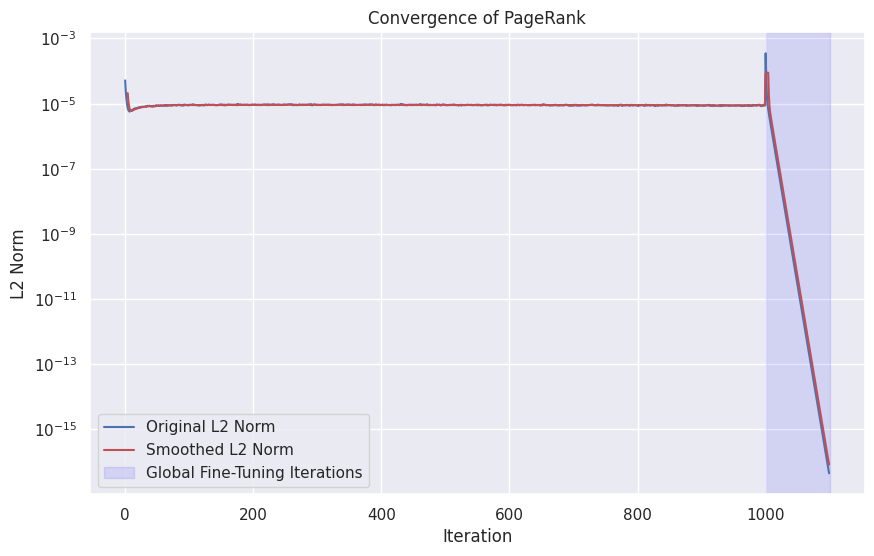

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement


In [49]:
weight_penalty = 'laplacian_SGD_pagerank'

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]
#norm_mat = D**-0.5 AD**-0.5
if weight_penalty == "laplacian":# This is essentially an attention score
    print('Using Laplacian penalty term, this is similar in concept to an attention score in GANs')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    attention_scores = normalized_matrix.sum(axis = 1)
    
elif weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
    # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = SGDpagerank(csr_matrix, num_iterations=1000,sampling_method='cyclic', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100)
    #'probability_based'
elif weight_penalty == "laplacian_pagerank":# This is essentially an attention score
    print('Using Laplacian-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = pagerank(csr_matrix, num_iterations=1000, d=0.85, tolerance=1e-6)
    

In [50]:
attention_scores.shape

(3426117, 1)

# Bayesian Sampling with iterated aggregation
- Bayesian sampling using the attention scores as priors, return_freq as observations and sampling from the posterior
- Two sampling operations
- First sampling operation counts the number of times a set of indices are sampled given the attention scores
- these are then converted into a second probability distribution. 
- We then finally sample from this probability distribution

In [121]:
indices = range(0,len(adata.obs))

def softmax_corrected(v):
    e_v = np.exp(v - np.max(v, axis=0))  # subtract max for numerical stability along the correct axis
    return e_v / e_v.sum(axis=0)
attention_scores

sf_attention = list((softmax_corrected(attention_scores)).flatten())
norm_attention = ((attention_scores / sum(attention_scores)).flatten())
total_sample_size = int(0.1*(len(adata.obs)))
# sample_indices_n = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)

N = 100  # number of iterations
all_sampled_indices = []

# Conduct sampling N times
for i in range(N):
    sample_indices = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)#norm_attention
    all_sampled_indices.extend(sample_indices)

# Count the frequency of each index
from collections import Counter
index_freq = Counter(all_sampled_indices)

# Convert the frequencies to probabilities
total_samples = sum(index_freq.values())
sampling_probabilities = {index: freq / total_samples for index, freq in index_freq.items()}

# Convert the dictionary keys and values to lists for sampling
sample_indices = list(sampling_probabilities.keys())
sample_probs = list(sampling_probabilities.values())

# Sample based on the computed probabilities
sampled_indices_from_output = np.random.choice(sample_indices, size=total_sample_size, p=sample_probs, replace=False)

# testing

In [122]:
adata_samp = adata[sampled_indices_from_output]
# make a true random sample
rand_indices = np.random.choice(indices, size=total_sample_size, replace=False)
adata_samp_rand = adata[rand_indices]

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


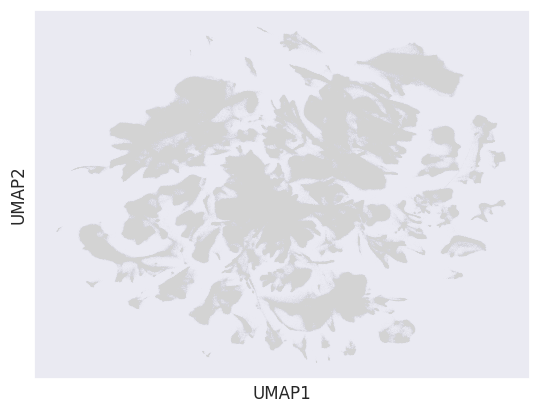

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


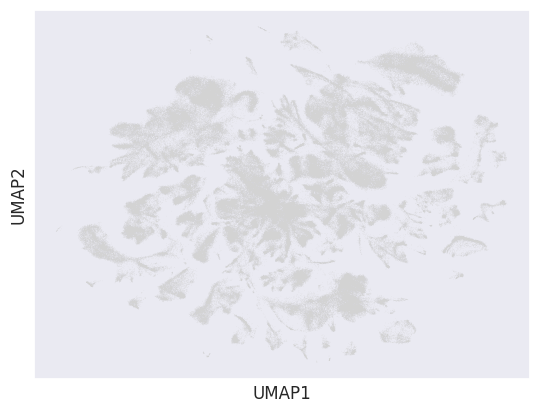

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


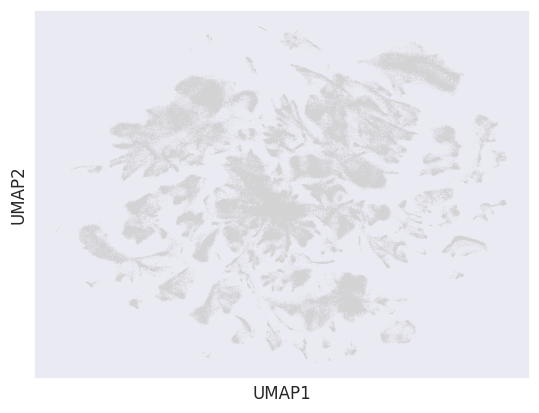

In [123]:
sc.pl.umap(adata)
sc.pl.umap(adata_samp)
sc.pl.umap(adata_samp_rand)

# Extract attention scores

In [124]:
sf_trans = (np.array(attention_scores)**0.1)*10
sf_trans = sf_trans**math.e
sf_trans = ((sf_trans-np.min(sf_trans))/np.max(sf_trans))*100
obs = adata.obs.copy()
obs['sf_trans'] = sf_trans
ct_c = obs.groupby(['cell_type']).median('sf_trans')
ct_c

,age,sf_trans
cell_type,,
ADH+ fibroblast,9.0,4.376627
AGM endothelial cells,6.0,4.341202
AGM epithelial cells,5.0,3.951692
AGM erythroid cells,6.0,2.201686
AGM haematopoietic cells,6.0,3.047140
...,...,...
aDC,15.0,4.282365
neural crest,13.0,4.378263
pDC,14.0,4.024581


In [126]:
ct_c.loc[['Myocytes','Myoblasts 1','Myoblasts 2']]

,age,sf_trans
cell_type,,
Myocytes,12.0,2.908146
Myoblasts 1,6.5,4.361903
Myoblasts 2,8.4,3.715795


In [107]:
np.max(ct_c['sf_trans'])

7.7778852559679335

In [106]:
np.min(ct_c['sf_trans'])

7.294577908137442

In [62]:
set(list(adata.obs['cell_type'].unique())) ^ set(list(adata_samp.obs['cell_type'].unique()))

{'KCNIP4+ neuron', 'Proliferating Schwann cells'}

In [61]:
len(adata.obs['cell_type'].unique())

491

In [58]:
len(adata_samp.obs['cell_type'].unique())

489

In [59]:
len(adata_samp_rand.obs['cell_type'].unique())

484

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

def graph_entropy(adj_matrix):
    # Compute the degree for each node
    degrees = np.sum(adj_matrix, axis=1)
    
    # Normalize the degrees to get the probability distribution
    prob_distribution = degrees / np.sum(degrees)
    
    # Compute the entropy
    entropy = -np.sum(prob_distribution * np.log(prob_distribution))
    return entropy

def structural_similarity(matrix1, matrix2, top_k=10):
    # Compute the eigenvalues for each matrix
    eigenvalues_1 = np.linalg.eigvals(matrix1)
    eigenvalues_2 = np.linalg.eigvals(matrix2)
    
    # Sort the eigenvalues in descending order
    eigenvalues_1 = sorted(eigenvalues_1, reverse=True)[:top_k]
    eigenvalues_2 = sorted(eigenvalues_2, reverse=True)[:top_k]
    
    # Compute cosine similarity between the top eigenvalues
    similarity = 1 - cosine(eigenvalues_1, eigenvalues_2)
    return similarity

# Test with your matrices
# entropy_orig = graph_entropy(orig_mat)
# entropy_sampled = graph_entropy(sampled_mat)
# similarity = structural_similarity(orig_mat, sampled_mat)

# print(f"Entropy of Original Matrix: {entropy_orig}")
# print(f"Entropy of Sampled Matrix: {entropy_sampled}")
# print(f"Structural Similarity: {similarity}")

In [ ]:
orig_mat = adata.obsp['connectivities'].todense()
rand_mat = adata_samp_rand.obsp['connectivities'].todense()
samp_mat = adata_samp.obsp['connectivities'].todense()

In [ ]:
structural_similarity(orig_mat,samp_mat)

In [71]:
def pagerank(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    However, the PageRank scores do not only depend on the total number of connections. They also take into account the quality of these connections, i.e., the connections to other well-connected nodes. So while a node with many connections might get a higher score, a node with fewer but more meaningful connections could also score highly.
    Moreover, the PageRank algorithm also includes the damping factor, which represents the probability of jumping to a random node in the graph. This ensures that all nodes have a non-zero probability of being 'visited', which can help prevent the algorithm from overly favoring well-connected nodes.
    """
    print("You are using whole-batch page_rank, this can be intense computationally for large data")
    N = M.shape[1]
    v = np.random.rand(N, 1)# v is the PageRank vector, initialized with random values. Each element of v corresponds to the PageRank score of a node in the graph.
    v = v / np.linalg.norm(v, 1)  # V is normalized by dividing each element by the sum of all elements (the L1 norm of the vector). This is done to ensure that the initial PageRank scores sum to 1.
    damping = ((1 - d) / N) * np.ones((N, 1))  # Damping factor, provides a probability that we will jump to another node
    last_v = np.ones((N, 1)) * np.inf # stores the current pagerank score set
    l2_dic = {}
    for _ in range(num_iterations):
        last_v = v # starts the storing of previous data and the loop
        v = d * M @ v + damping # The new scores are a weighted combination of the old scores (d * M @ v) and the damping vector (damping). The matrix-vector multiplication M @ v calculates the sum of the scores of the neighbors for each node, accounting for the weight of the edges.
        if np.linalg.norm(v - last_v) < tolerance: #This line checks whether the PageRank scores have converged. If the L2 norm (Euclidean distance) between the current and previous scores is less than tolerance, the function considers that the algorithm has converged and breaks out of the loop.
            l2_dic[_] = np.linalg.norm(v - last_v)
            print('Converged at iteration {}'.format(_))
            break
    return v

# Convert your sparse matrix to a csr_matrix if it's not already
csr_matrix = normalized_matrix.tocsr()

# Compute the PageRank of each node in the graph
pagerank_scores = pagerank(csr_matrix, num_iterations=10000, d=0.85, tolerance=1e-6)
pagerank_scores

Converged at iteration 10


array([[9.21256131e-07],
       [1.85810021e-06],
       [1.28624031e-06],
       ...,
       [1.06286055e-06],
       [2.24428016e-06],
       [1.09276594e-06]])

In [ ]:
def pagerank(M, num_iterations=100, d=0.85, tolerance=1e-6):
    """
    Calculate the PageRank of each node in a graph.
    
    Parameters:
    M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    num_iterations (int): The maximum number of iterations to perform.
    d (float): The damping factor.
    tolerance (float): The tolerance for convergence.
    
    Returns:
    numpy.ndarray: The PageRank score for each node in the graph.
    """
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    damping = ((1 - d) / N) * np.ones((N, 1))
    last_v = np.ones((N, 1)) * np.inf
    l2_dic = {}
    for _ in range(num_iterations):
        last_v = v
        v = d * M @ v + damping
        l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(_))
            break
            
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_norm_dic.keys()), list(l2_norm_dic.values()))
    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.grid(True)
    plt.show()

    return v, l2_dic


def SGDpagerank(M, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, 
             full_batch_update_iters=10, dip_window=5, plateau_iterations=5, sampling_method='probability_based'):
    """
    Calculate the PageRank of each node in a graph using a mini-batch SGD approach.

    Parameters:
    - M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    - num_iterations (int): The maximum number of iterations to perform.
    - mini_batch_size (int): Number of nodes to sample in each iteration.
    - initial_learning_rate (float): Initial learning rate for the SGD updates.
    - tolerance (float): Convergence threshold.
    - d (float): Damping factor.
    - full_batch_update_iters (int): Number of iterations for the full-batch update phase.
    - dip_window (int): Window size for smoothing L2 norms.
    - plateau_iterations (int): Number of consecutive iterations where the gradient should remain stable for early stopping.
    - sampling_method (str): Method to sample nodes ('probability_based' or 'cyclic').

    Returns:
    - numpy.ndarray: The PageRank score for each node in the graph.
    - dict: L2 norms for each iteration.
    """
    
    # Initialize the size of the matrix
    N = M.shape[1]
    
    # Initialize PageRank vector with random values and normalize
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    
    # Initialize last PageRank vector to infinity for convergence checks
    last_v = np.ones((N, 1)) * np.inf
    
    # Dictionary to store L2 norms for each iteration
    l2_dic = {}
    
    # Set to keep track of visited nodes (for cyclic sampling)
    visited_nodes = set()
    
    # Initialize counters and lists for plateau and dip detection
    plateau_count = 0
    dips_detected = 0
    dip_positions = []

    # Initialize an array to keep track of node visit counts (for probability-based sampling)
    visited_counts = np.zeros(N)

    for iter_ in range(num_iterations):
        # Decay the learning rate to ensure convergence
        learning_rate = initial_learning_rate / ((1 + iter_)/10)
        
        # Probability-based sampling
        if sampling_method == 'probability_based':
            probabilities = 1 / (1 + visited_counts)
            probabilities /= probabilities.sum()
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        # Cyclic sampling
        elif sampling_method == 'cyclic':
            if len(visited_nodes) < N:
                remaining_nodes = list(set(range(N)) - visited_nodes)
                mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
            else:
                mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
            # Update the set of visited nodes
            visited_nodes.update(mini_batch_indices)
        
        # Update node visit counts
        visited_counts[mini_batch_indices] += 1
        
        # Extract the mini-batch from the matrix and the PageRank vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices]
        
        # Store the current PageRank values for convergence checks
        last_v = v_mini_batch
        
        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rate * M_mini_batch @ v) + ((1 - d) / N)
        v[mini_batch_indices] = v_mini_batch
        
        # Compute and store the L2 norm of the difference between the current and last PageRank values
        l2_norm = np.linalg.norm(v_mini_batch - last_v)
        l2_dic[iter_] = l2_norm
        
        # Compute smoothed L2 norms for dip detection
        if iter_ > dip_window:
            smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
            gradient = smoothed_values[-1] - smoothed_values[-2]
            
            # Detect dips in the smoothed L2 norms
            if gradient < -1.5 * np.std(smoothed_values):
                dips_detected += 1
                dip_positions.append(iter_)

        # Check for convergence
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(iter_))
            break
        
        # Early stopping based on smoothed L2 norms
        gradient_variance_window = 10
        if iter_ > gradient_variance_window:
            gradient_values = np.diff(smoothed_values)
            variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
            if sampling_method == 'probability_based' and dips_detected == 1:
                if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            elif sampling_method == 'cyclic' and dips_detected > 1:
                if abs(gradient) < 0.5 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            # If the gradient has been stable for a number of iterations, stop early
            if plateau_count >= plateau_iterations:
                print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
                break

    # If the algorithm hasn't converged in the given number of iterations, display a message
    if iter_ == num_iterations-1:
        print('pagerank model did not converge during the mini-batch phase')
    
    # Refine the PageRank values using full-batch updates
    print("Proceeding on to perform fine-tuning across full-batch")
    for _ in range(full_batch_update_iters):
        last_v_global = v.copy()
        v = d * (M @ v) + ((1 - d) / N)
        l2_norm_global = np.linalg.norm(v - last_v_global)
        l2_dic[iter_ + _ + 1] = l2_norm_global
    
    # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
    smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
    plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
    for dip in dip_positions:
        plt.axvline(x=dip, color='g', linestyle='--')
    
    if plateau_count >= plateau_iterations:
        plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

    # Highlight the global fine-tuning iterations
    plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if sampling_method == 'probability_based':
        print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
        print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
    elif sampling_method == 'cyclic':
        print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
        print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    
    return v, l2_dic


# Compute the PageRank of each node in the graph
#pagerank_scores, l2_norm_dic = pagerank(csr_matrix, num_iterations=10000, d=0.85, tolerance=1e-6)

pagerank_scores, l2_norm_dic = SGDpagerank(csr_matrix, num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100)

In [74]:
     l2_dic = {}
    l2_norm = np.linalg.norm(v - last_v)
        l2_dic[_] = l2_norm
        
        plt.figure(figsize=(10,6))
plt.plot(list(l2_norm_dic.keys()), list(l2_norm_dic.values()))
plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('L2 Norm')
plt.title('Convergence of PageRank')
plt.grid(True)
plt.show()

pagerank_scores


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 3)